# Transfer Learning Example

We aim to train a *binary classifier* on the [INRIA Horses](https://calvin-vision.net/datasets/inria-horses/) dataset, which contains two classes of pictures: (i) pictures of horses, (ii) pictures NOT containing horses.

We compare 2 approaches:

- applying transfer learning on a pre-trained ResNet-50 model
- training from scratch ResNet-50 on the INRIA dataset

## Getting Data

Download the dataset from the class materials. Compared to the original version, the directory structure has been prepared to simplify data loading.

In [ ]:
DATASET_DIR="/home/gabriele/inria-horses-v103"

In [4]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_color_image(image):
    fig = plt.figure()
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

2023-11-23 09:25:03.368688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 09:25:03.468761: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
import imageio

def process_img (filename):
    image = imageio.imread(filename)
    resized = tf.image.resize([image], (224,224))

    inputs = keras.applications.resnet50.preprocess_input(resized)
    Y_proba = model.predict(inputs)
    top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=1)
    for image_index in range(len(resized)):
        print("Image #{}".format(image_index))
        for class_id, name, y_proba in top_K[image_index]:
            print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
        print()

In [6]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

2023-11-23 09:25:05.157865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let's see what ResNet-50, trained on ImageNet, predicts for horse pictures:

In [7]:
import os
filenames=[]
DIR=os.path.join(DATASET_DIR,"pos")
for entry in os.listdir(DIR):
    if "jpg" in entry:
        filenames.append(os.path.join(DIR,entry))
for filename in filenames[:20]:
    process_img(filename)

/tmp/ipykernel_8370/1612986526.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


1/1 [==============================] - 0s 458ms/step
Image #0
  n03388043 - fountain     43.82%

1/1 [==============================] - 0s 54ms/step
Image #0
  n01582220 - magpie       18.02%

1/1 [==============================] - 0s 54ms/step
Image #0
  n02422106 - hartebeest   35.62%

1/1 [==============================] - 0s 57ms/step
Image #0
  n02109047 - Great_Dane   17.06%

1/1 [==============================] - 0s 57ms/step
Image #0
  n03445924 - golfcart     93.80%

1/1 [==============================] - 0s 51ms/step
Image #0
  n02389026 - sorrel       98.79%

1/1 [==============================] - 0s 57ms/step
Image #0
  n02389026 - sorrel       62.38%

1/1 [==============================] - 0s 51ms/step
Image #0
  n02389026 - sorrel       33.22%

1/1 [==============================] - 0s 55ms/step
Image #0
  n03218198 - dogsled      65.96%

1/1 [==============================] - 0s 57ms/step
Image #0
  n02389026 - sorrel       99.33%

1/1 [==============================] - 

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_DIR,
  validation_split=0.2,
      subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=32)
validation_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=32)


NameError: name 'DATASET_DIR' is not defined

In [68]:
class_names = train_ds.class_names
print(class_names)


['neg', 'pos']


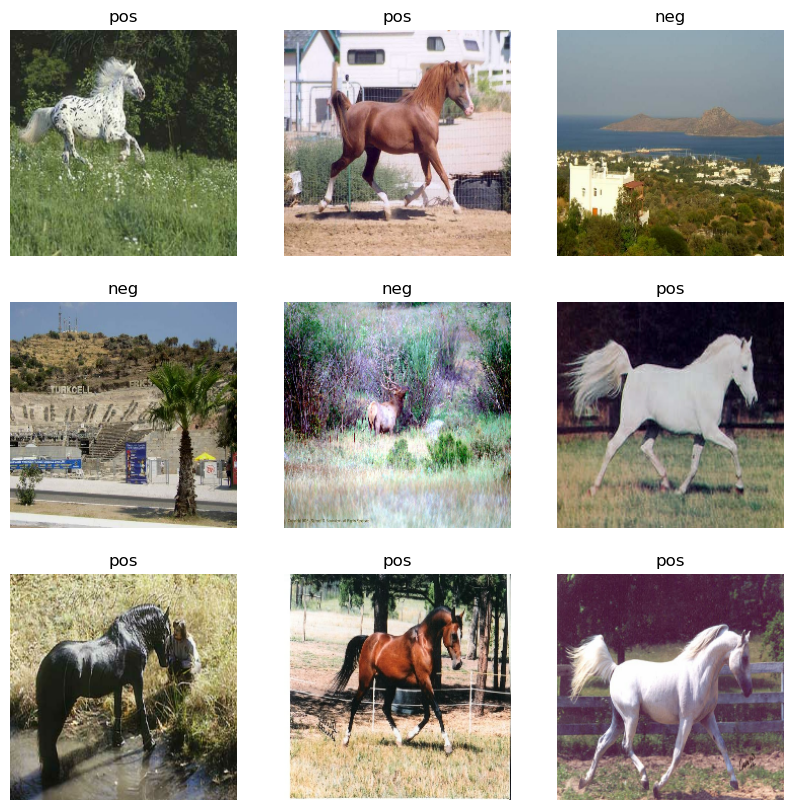

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [70]:
base_model = keras.applications.ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 2049      
                                                           

In [71]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 15
model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/15
9/9 [==============================] - 13s 1s/step - loss: 0.7391 - binary_accuracy: 0.4926 - val_loss: 0.7169 - val_binary_accuracy: 0.7500
Epoch 2/15
9/9 [==============================] - 11s 1s/step - loss: 0.6832 - binary_accuracy: 0.5441 - val_loss: 0.6472 - val_binary_accuracy: 0.6176
Epoch 3/15
9/9 [==============================] - 12s 1s/step - loss: 0.6601 - binary_accuracy: 0.5662 - val_loss: 0.6483 - val_binary_accuracy: 0.7206
Epoch 4/15
9/9 [==============================] - 11s 1s/step - loss: 0.6391 - binary_accuracy: 0.6213 - val_loss: 0.6369 - val_binary_accuracy: 0.7206
Epoch 5/15
9/9 [==============================] - 12s 1s/step - loss: 0.6307 - binary_accuracy: 0.6140 - val_loss: 0.6108 - val_binary_accuracy: 0.7059
Epoch 6/15
9/9 [==============================] - 12s 1s/step - loss: 0.6275 - binary_accuracy: 0.5993 - val_loss: 0.6144 - val_binary_accuracy: 0.7353
Epoch 7/15
9/9 [==============================] - 12s 1s/step - loss: 0.5876 - binary_ac

In [72]:


# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
) (x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
newmodel = keras.Model(inputs, outputs)

newmodel.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 2049      
                                                           

In [73]:
newmodel.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
newmodel.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/20
9/9 [==============================] - 35s 3s/step - loss: 0.3469 - binary_accuracy: 0.8419 - val_loss: 475.2451 - val_binary_accuracy: 0.4265
Epoch 2/20
9/9 [==============================] - 27s 3s/step - loss: 0.1747 - binary_accuracy: 0.9191 - val_loss: 443.9498 - val_binary_accuracy: 0.4265
Epoch 3/20
9/9 [==============================] - 27s 3s/step - loss: 0.1186 - binary_accuracy: 0.9596 - val_loss: 858.9693 - val_binary_accuracy: 0.4265
Epoch 4/20
9/9 [==============================] - 27s 3s/step - loss: 0.2360 - binary_accuracy: 0.8971 - val_loss: 14068104.0000 - val_binary_accuracy: 0.4265
Epoch 5/20
1/9 [==>...........................] - ETA: 24s - loss: 0.3572 - binary_accuracy: 0.9062

KeyboardInterrupt: 